## **-- PREPARATION --**

Imports

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Création du dataframe

In [3]:
#Création d'un dictionnaire vide
saved_dict = {}

In [4]:
#Lecture des datasets

dfs = []
for i in range(1,5):
    path = '/content/drive/MyDrive/UNSW-NB15_{}.csv'  # 4 csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concaténer en un df

<ipython-input-4-e689d2af156b>:6: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))
<ipython-input-4-e689d2af156b>:6: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))


In [5]:
#Ajout des noms de colonnes ! Allons les chercher dans NUSW-NB15_features.csv :
df_col = pd.read_csv('/content/drive/MyDrive/NUSW-NB15_features.csv', encoding='ISO-8859-1')


#Harmonisation des noms de colonnes : minuscules partout, retirer les espaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())


#Renommage des noms de colonnes
all_data.columns = df_col['Name']


#Sauvegarde des infos, utiles ultérieurement pour transformer les données brutes des tests.
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()


In [6]:
#Suppression du data frame n'apportant que le header et le descriptif
del df_col

In [7]:
all_data.shape

all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


## **-- NETTOYAGE --**

Imports supplémentaires (visualisations, machine learning...)

In [8]:
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict


Création du DF train que nous utiliserons pour une évaluation indépendante, éviter le surapprentissage, une optimisation des hyperparamètres et bien sûr la validation croisée

In [9]:
# Séparation des données en train et test
# Toutes les opérations suivantes seront effectuées uniquement sur les données de train.
train, test = train_test_split(all_data, test_size=0.2, random_state=1)

In [10]:
# Suppression du dataframe créé précédemment, car nous n'en avons plus besoin
del all_data

In [11]:
print("train =", train.shape, "test =", test.shape)

train = (2032037, 49) test = (508010, 49)


Suppression des valeurs manquantes

In [12]:
#Vérification des valeurs nulles
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [13]:
train['attack_cat'].value_counts()

Generic             172425
Exploits             35658
 Fuzzers             15279
DoS                  13070
 Reconnaissance       9778
 Fuzzers              4039
Analysis              2124
Backdoor              1463
Reconnaissance        1405
 Shellcode            1021
Backdoors              431
Shellcode              176
Worms                  144
Name: attack_cat, dtype: int64

Les "Pas d'attaque" sont renommées en "normal".

In [14]:
train['attack_cat'] = train.attack_cat.replace("backdoors", "backdoor")

In [15]:
train['attack_cat'] = train.attack_cat.fillna(value="normal").apply(lambda x: x.strip().lower())
train['attack_cat'].value_counts()

normal            1775024
generic            172425
exploits            35658
fuzzers             19318
dos                 13070
reconnaissance      11183
analysis             2124
backdoor             1463
shellcode            1197
backdoors             431
worms                 144
Name: attack_cat, dtype: int64

Remplissage de valeurs nulles (NaN) dans les colonnes "ct_flw_http_mthd" et "is_ftp_login" par "0"

In [16]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)


train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)


In [17]:
#Résultat ?
train.isnull().sum().sum()

0

## Matrice de corrélation
Pour vérifier la corrélation entre toutes les informations, retirer les doublons, épurer le nombre de colonnes

<Axes: xlabel='Name', ylabel='Name'>

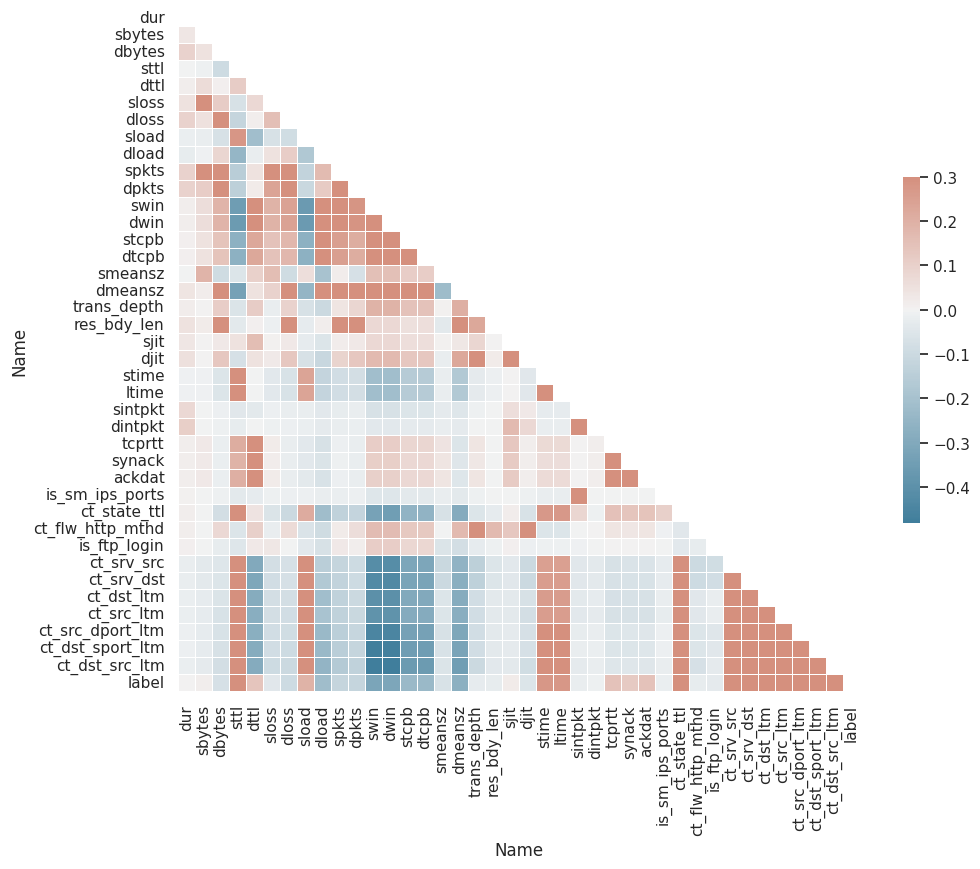

In [18]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

'''# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))'''

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})